In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
import glob
import cv2
from concurrent import futures
import threading


# set cell_images folder path for dataset
root ="/content/gdrive/My Drive/Malaria_dataset/cell_images"

# read dataset
base_dir = os.path.join('/content/gdrive/My Drive/Malaria_dataset/cell_images')
infected_dir = os.path.join(base_dir,'Parasitized')
healthy_dir = os.path.join(base_dir,'Uninfected')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13794)

In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
1,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
2,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
3,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria
4,/content/gdrive/My Drive/Malaria_dataset/cell_...,malaria


In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(17370,) (1931,) (8272,)
Train: Counter({'healthy': 8766, 'malaria': 8604}) 
Val: Counter({'malaria': 979, 'healthy': 952}) 
Test: Counter({'malaria': 4196, 'healthy': 4076})


In [0]:

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_1: working on img num: 5000
ThreadPoolExecutor-0_2: working on img num: 10000
ThreadPoolExecutor-0_18: working on img num: 15000
ThreadPoolExecutor-0_19: working on img num: 17369
Min Dimensions: [40 46  3]
Avg Dimensions: [133.01278066 132.55129534   3.        ]
Median Dimensions: [130. 130.   3.]
Max Dimensions: [382 394   3]


In [7]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    # Apply bilateral filter with d = 15,  
    # sigmaColor = sigmaSpace = 75.
    img = cv2.bilateralFilter(img, 3,7, 9) 
    img = cv2.resize(img, dsize=IMG_DIMS, interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_0: working on img num: 5000
ThreadPoolExecutor-1_6: working on img num: 10000
ThreadPoolExecutor-1_19: working on img num: 15000
ThreadPoolExecutor-1_5: working on img num: 17369

Loading Validation Images:
ThreadPoolExecutor-1_11: working on img num: 0
ThreadPoolExecutor-1_18: working on img num: 1930

Loading Test Images:
ThreadPoolExecutor-1_9: working on img num: 0
ThreadPoolExecutor-1_6: working on img num: 5000
ThreadPoolExecutor-1_4: working on img num: 8271


((17370, 125, 125, 3), (1931, 125, 125, 3), (8272, 125, 125, 3))

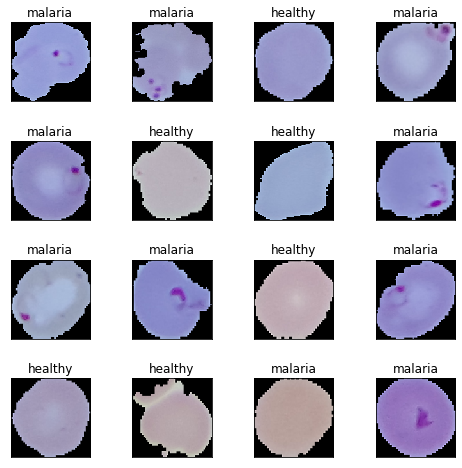

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [9]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 50
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)
# change version of tensorflow
%tensorflow_version 2.x
print(train_labels[:6], train_labels_enc[:6])

TensorFlow 2.x selected.
['healthy' 'healthy' 'healthy' 'healthy' 'healthy' 'healthy'] [0 0 0 0 0 0]


In [10]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_random_seed(42)
tf.random.set_seed(42)
tf.__version__

'2.0.0'

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['healthy', 'healthy', 'healthy', 'healthy', 'healthy']


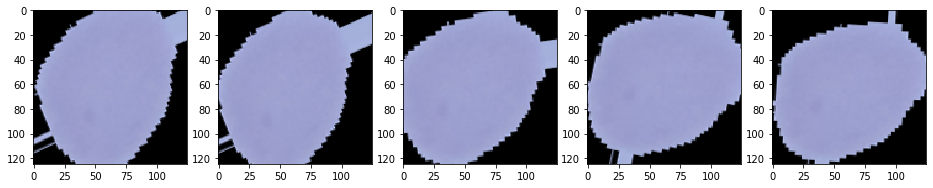

In [12]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

# build image augmentation generators
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [0]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 128)       0     

In [0]:
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

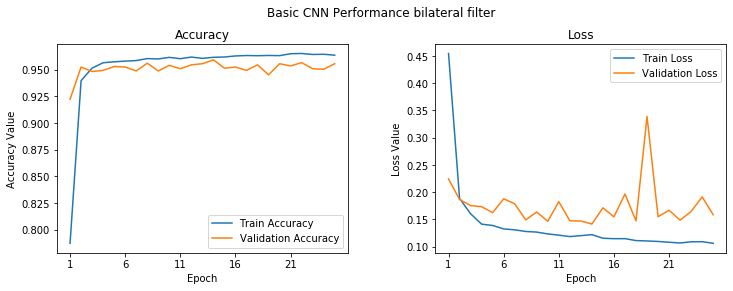

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance bilateral filter', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('malaria_detector_cnn_bilateral.h5')

In [13]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

In [0]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", 
      sum([1 for l in model.layers if l.trainable]))


Total Layers: 28
Total trainable layers: 6


In [0]:
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/50
542/542 [==============================] - 83s 154ms/step - loss: 0.5641 - accuracy: 0.7049 - val_loss: 0.4224 - val_accuracy: 0.8021
Epoch 2/50
542/542 [==============================] - 80s 148ms/step - loss: 0.4036 - accuracy: 0.8220 - val_loss: 0.3287 - val_accuracy: 0.8526
Epoch 3/50
542/542 [==============================] - 81s 149ms/step - loss: 0.3447 - accuracy: 0.8503 - val_loss: 0.3645 - val_accuracy: 0.8266
Epoch 4/50
542/542 [==============================] - 80s 148ms/step - loss: 0.3112 - accuracy: 0.8677 - val_loss: 0.3141 - val_accuracy: 0.8490
Epoch 5/50
542/542 [==============================] - 81s 149ms/step - loss: 0.2933 - accuracy: 0.8788 - val_loss: 0.2769 - val_accuracy: 0.8776
Epoch 6/50
542/542 [==============================] - 80s 148ms/step - loss: 0.2857 - accuracy: 0.8840 - val_loss: 0.2972 - val_accuracy: 0.8672
Epoch 7/50
542/542 [==============================] - 80s 148ms/step - loss: 0.2745 - accuracy: 0.8875 - val_loss: 0.2526 - val_ac

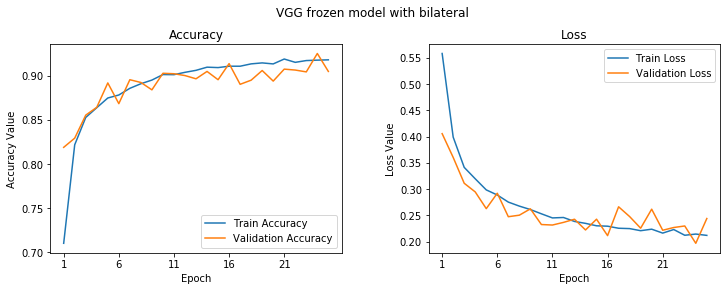

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG frozen model with bilateral ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('vgg_bilateral2.h5')

In [0]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1' , 'block3_conv1', 'block2_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 24


In [0]:
import datetime
logdir = os.path.join('c:\\Users\\Dell\\Documents\\python_projects', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/25
542/542 [==============================] - 99s 182ms/step - loss: 0.1811 - accuracy: 0.9353 - val_loss: 0.1506 - val_accuracy: 0.9552
Epoch 2/25
542/542 [==============================] - 99s 182ms/step - loss: 0.1228 - accuracy: 0.9593 - val_loss: 0.1309 - val_accuracy: 0.9594
Epoch 3/25
542/542 [==============================] - 98s 181ms/step - loss: 0.1107 - accuracy: 0.9625 - val_loss: 0.1418 - val_accuracy: 0.9573
Epoch 4/25
542/542 [==============================] - 98s 181ms/step - loss: 0.1063 - accuracy: 0.9631 - val_loss: 0.1274 - val_accuracy: 0.9589
Epoch 5/25
542/542 [==============================] - 98s 181ms/step - loss: 0.1006 - accuracy: 0.9659 - val_loss: 0.1282 - val_accuracy: 0.9620
Epoch 6/25
542/542 [==============================] - 98s 181ms/step - loss: 0.0966 - accuracy: 0.9679 - val_loss: 0.1290 - val_accuracy: 0.9589
Epoch 7/25
542/542 [==============================] - 98s 180ms/step - loss: 0.0959 - accuracy: 0.9671 - val_loss: 0.1297 - val_ac

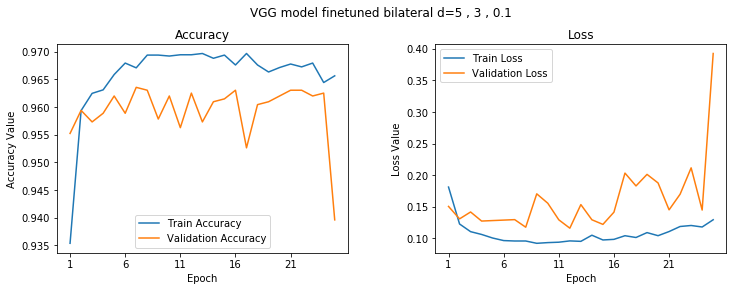

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG model finetuned bilateral d=5 , 3 , 0.1', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [0]:
model.save('Vgg_finetuned_bilateralv2.h5')

In [0]:
#scale test data
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((8272, 125, 125, 3), (8272,))

In [0]:
# Load Saved Deep Learning Models
#basic_cnn = tf.keras.models.load_model('/content/malaria_detector_cnn_bilateral.h5')
vgg_frz = tf.keras.models.load_model('/content/vgg_bilateral2.h5')
vgg_ft = tf.keras.models.load_model('/content/Vgg_finetuned_bilateralv2.h5')

# Make Predictions on Test Data
#basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

#basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                 for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [0]:
from google.colab import files 
uploaded = files.upload()

In [0]:
import model_evaluation_utils as meu
import pandas as pd

#basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)
#vgg_frz_metrics_b = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels_b)
#vgg_ft_metrics_b = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels_b)

pd.DataFrame([ vgg_frz_metrics , vgg_ft_metrics], 
             index=['VGG-19 Frozen', 'VGG-19 Finetuned'])



,Accuracy,Precision,Recall,Sensitivity,specificity,F1 Score
VGG-19 Frozen,48.9724,48.7093,48.9724,49.0324,48.3954,38.9844
VGG-19 Finetuned,94.1973,94.6923,94.1973,89.8846,99.3624,94.1858
